In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.src.layers import LSTM, Dropout, Dense
from keras import Sequential
from keras.src.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
# Pobieramy dane spolki Apple Inc (AAPL) z okresu 01.01.2020-01.01.2024
# Mozliwe jest pobranie parametrow innych spolek i wybranie innego okresu poddanego analizie
aapl_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')
aapl_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.716064,72.776591,71.466805,71.721011,135480400
2020-01-03,72.009117,72.771745,71.783962,71.941328,146322800
2020-01-06,72.582909,72.621646,70.876075,71.127866,118387200
2020-01-07,72.241547,72.849224,72.021231,72.592594,108872000
2020-01-08,73.403641,73.706271,71.943751,71.943751,132079200


In [3]:
print(aapl_data.isnull().sum())
aapl_data.ffill(inplace=True)

Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
aapl_data_scaled = scaler.fit_transform(aapl_data['Close'].values.reshape(-1, 1))
aapl_data_scaled

array([[0.1282037 ],
       [0.1232419 ],
       [0.12726913],
       ...,
       [0.96539538],
       [0.96839535],
       [0.96106977]])

In [5]:
X = [] # wejsciowe sekwencje
y = [] # wartosci, ktore model ma przewidywac
# Zaczynamy od i = 60, poniewaz do stworzenia pierwszej sekwencji wykorzystywane jest 60 pierwszych dni, az do konca danych wejsciowych
for i in range(60, len(aapl_data_scaled)):
 X.append(aapl_data_scaled[i - 60 : i, 0]) # 60 poprzednich wartosci jest pobierana jako sekwencja wejsciowa
 y.append(aapl_data_scaled[i, 0]) # Pobierana jest wartosci z indeksu i, czyli wartosci akcji jaka przypada bezposcrednio po analizowanej 60-dniowej sekwencji

# Podzial danych na dane treningowe (80%) i testowe (20%) - parametr test_size=0.2
# Parametr shuffle=False nie miesza danych, poniewaz w przypadku szeregow czasowych kolejnosc ma znaczenie
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [6]:
X_train, y_train = np.array(X_train), np.array(y_train) # Konwersja danych na tablice NumPy
# samples = X_train.shape[0] (liczba probek)
# time_steps = X_train.shape[1] (dlugosc sekwencji)
# 1 - features (liczba cech)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [7]:
model = Sequential() # Tworzenie modelu sekwencyjnego, gdzie warstwy sa dodawane jedna po drugiej
model.add(LSTM(150, return_sequences=True,
  input_shape=(X_train.shape[1], 1))) # return_sequences=True - zwrocenie pelnej sekwenscji do nastepnej warstwy
model.add(Dropout(0.2)) # Dodanie warstwy Dropout z rate=0.2, w celu wylaczenia 20% neuronow podczas treningu w celu zapobiegania overfittingu
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150))
model.add(Dropout(0.2))
model.add(Dense(1)) # Ostatnia warstwa, gdzie liczba neuronow wynosi, 1, poniewaz przewidywana jest pojedyncza wartosc - cena akcji nastepnego dnia
model.compile(loss='mean_squared_error', optimizer='adam') # funkcja straty to MSE, co jest typowe dla regresji
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 150)        │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 150)        │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 150)        │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 633,151 (2.42 MB)

 Trainable params: 633,151 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, callbacks = [monitor], verbose=1, epochs=100)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 0.1389 - val_loss: 0.0169
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0196 - val_loss: 0.0082
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0084 - val_loss: 0.0039
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0059 - val_loss: 0.0037
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/st

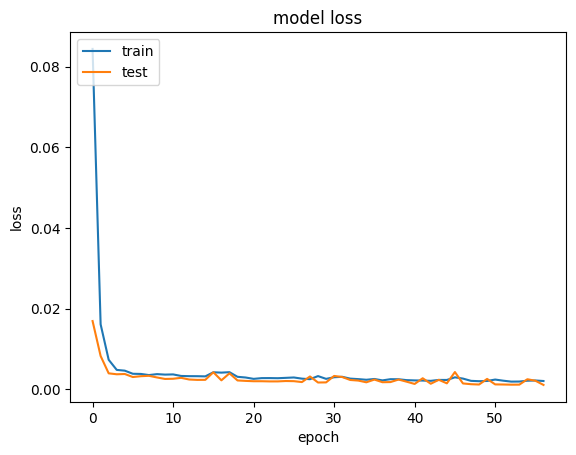

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) #Zmiana kształtu zbioru X_test

In [11]:
test_loss = model.evaluate(X_test, y_test) # Ewaluacja modelu na zbiorze testowym
print("Test Loss: ", test_loss) # Wyznaczenie test loss

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015     
Test Loss:  0.001850565429776907


In [12]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Mean Absolute Error:  0.03662390269098095
Root Mean Square Error:  0.0018505653712714801


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


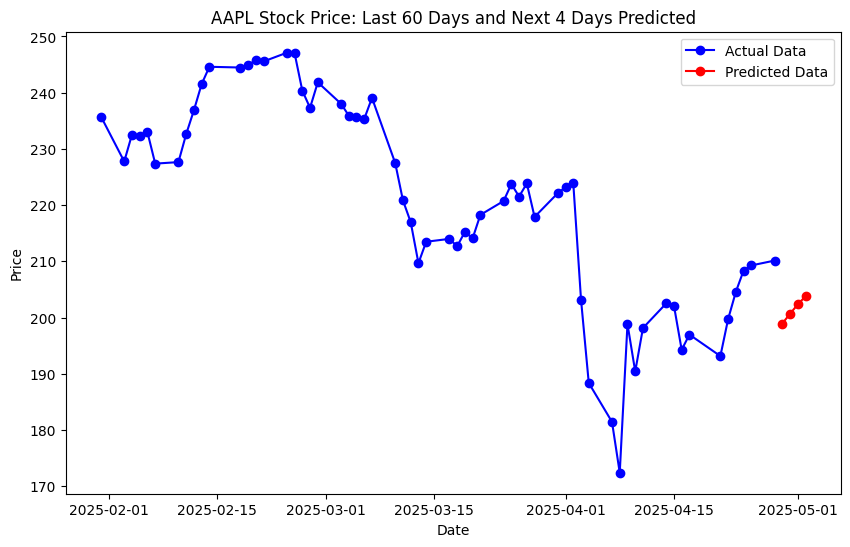

In [13]:
# Wczytanie danych z ostatnich 64 dni
data = yf.download('AAPL', period='64d', interval='1d')
# Wybranie odpowiedniej cechy i zmiana kształtu zminnej oraz przeprowadzenie normalizacji
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)
# Na podstawie modelu przeprowadzono predykcje wartosci akcji z 4 ostatnich dni
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)
for i in range(4):
 next_prediction = model.predict(current_batch)
 next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
 current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
 predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])
# Tworzenie listy zawierajacej daty predkcji
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)
# Dodanie predykcji do DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])
# Polaczenie aktualnych danych i predykcji
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:]
# Przedstawienie na wykresie aktualnych danych z ostatnich 60 dni
plt.figure(figsize=(10, 6))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')
# Przedstawienie danych z ostatnich 4 dni
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')
plt.title("AAPL Stock Price: Last 60 Days and Next 4 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [14]:
#Zadanie dla danych od Apple z sekwencjami 30 i cecha Volume
aapl_data_scaled2 = scaler.fit_transform(aapl_data['Volume'].values.reshape(-1, 1))
aapl_data_scaled2

array([[0.27687628],
       [0.30381649],
       [0.23440467],
       ...,
       [0.0597309 ],
       [0.02485106],
       [0.04616713]])

In [15]:
X = [] # wejsciowe sekwencje
y = [] # wartosci, ktore model ma przewidywac
# Zaczynamy od i = 30, poniewaz do stworzenia pierwszej sekwencji wykorzystywane jest 30 pierwszych dni, az do konca danych wejsciowych
for i in range(30, len(aapl_data_scaled2)):
 X.append(aapl_data_scaled2[i - 30 : i, 0]) # 30 poprzednich wartosci jest pobierana jako sekwencja wejsciowa
 y.append(aapl_data_scaled2[i, 0]) # Pobierana jest wartosci z indeksu i, czyli wartosci akcji jaka przypada bezposcrednio po analizowanej 30-dniowej sekwencji

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [16]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [17]:
model2 = Sequential() # Tworzenie modelu sekwencyjnego, gdzie warstwy sa dodawane jedna po drugiej
model2.add(LSTM(150, return_sequences=True,
input_shape=(X_train.shape[1], 1))) # return_sequences=True - zwrocenie pelnej sekwenscji do nastepnej warstwy
model2.add(Dropout(0.2)) # Dodanie warstwy Dropout z rate=0.2, w celu wylaczenia 20% neuronow podczas treningu w celu zapobiegania overfittingu
model2.add(LSTM(150, return_sequences=True))
model2.add(LSTM(150, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(150))
model2.add(Dropout(0.2))
model2.add(Dense(1)) # Ostatnia warstwa, gdzie liczba neuronow wynosi, 1, poniewaz przewidywana jest pojedyncza wartosc - cena akcji nastepnego dnia
model2.compile(loss='mean_squared_error', optimizer='adam') # funkcja straty to MSE, co jest typowe dla regresji
model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 150)        │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 30, 150)        │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 30, 150)        │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 633,151 (2.42 MB)

 Trainable params: 633,151 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
monitor2 = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, verbose=1, mode='auto', restore_best_weights=True)
history2 = model2.fit(X_train, y_train, validation_split=0.2, callbacks = [monitor2], verbose=1, epochs=100)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0336 - val_loss: 0.0054
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0151 - val_loss: 0.0033
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0148 - val_loss: 0.0051
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0127 - val_loss: 0.0032
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0130 - val_loss: 0.0029
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0115 - val_loss: 0.0030
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0115 - val_loss: 0.0082
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0104 - val_loss: 0.0030
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0124 - val_loss: 0.0035
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0093 - val_loss: 0.0031
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0091 - val_loss: 0.0029
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

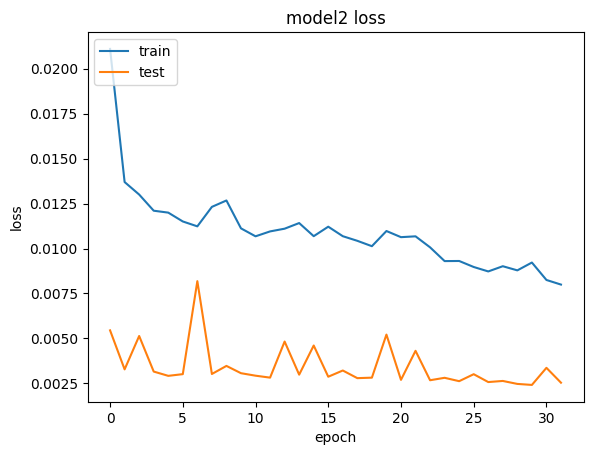

In [19]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) #Zmiana kształtu zbioru X_test
test_loss = model2.evaluate(X_test, y_test) # Ewaluacja modelu na zbiorze testowym
print("Test Loss: ", test_loss) # Wyznaczenie test loss

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 
Test Loss:  0.001875828136689961


In [21]:
y_pred = model2.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Mean Absolute Error:  0.032133389707609
Root Mean Square Error:  0.001875828094271557


In [22]:
#Zadanie dla danych od Apple z sekwencjami 120 i cecha High
aapl_data_scaled3 = scaler.fit_transform(aapl_data['High'].values.reshape(-1, 1))
aapl_data_scaled3

array([[0.12116984],
       [0.12113595],
       [0.12008614],
       ...,
       [0.95745136],
       [0.9655161 ],
       [0.96370844]])

In [23]:
X = []
y = []
for i in range(120, len(aapl_data_scaled2)):
 X.append(aapl_data_scaled2[i - 120 : i, 0])
 y.append(aapl_data_scaled2[i, 0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [24]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [25]:
model3 = Sequential() # Tworzenie modelu sekwencyjnego, gdzie warstwy sa dodawane jedna po drugiej
model3.add(LSTM(150, return_sequences=True,
input_shape=(X_train.shape[1], 1))) # return_sequences=True - zwrocenie pelnej sekwenscji do nastepnej warstwy
model3.add(Dropout(0.2)) # Dodanie warstwy Dropout z rate=0.2, w celu wylaczenia 20% neuronow podczas treningu w celu zapobiegania overfittingu
model3.add(LSTM(150, return_sequences=True))
model3.add(LSTM(150, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(150))
model3.add(Dropout(0.2))
model3.add(Dense(1)) # Ostatnia warstwa, gdzie liczba neuronow wynosi, 1, poniewaz przewidywana jest pojedyncza wartosc - cena akcji nastepnego dnia
model3.compile(loss='mean_squared_error', optimizer='adam') # funkcja straty to MSE, co jest typowe dla regresji
model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 120, 150)       │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 120, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 120, 150)       │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 120, 150)       │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 633,151 (2.42 MB)

 Trainable params: 633,151 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
monitor3 = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, verbose=1, mode='auto', restore_best_weights=True)
history3 = model3.fit(X_train, y_train, validation_split=0.2, callbacks = [monitor3], verbose=1, epochs=100)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0197 - val_loss: 0.0037
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0078 - val_loss: 0.0045
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0092 - val_loss: 0.0042
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0074 - val_loss: 0.0029
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0078 - val_loss: 0.0030
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0090 - val_loss: 0.0063
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0099 - val_loss: 0.0032
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0099 - val_loss: 0.0038
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0090 - val_loss: 0.0028
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0062 - val_loss: 0.0029
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0074 - val_loss: 0.0040
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

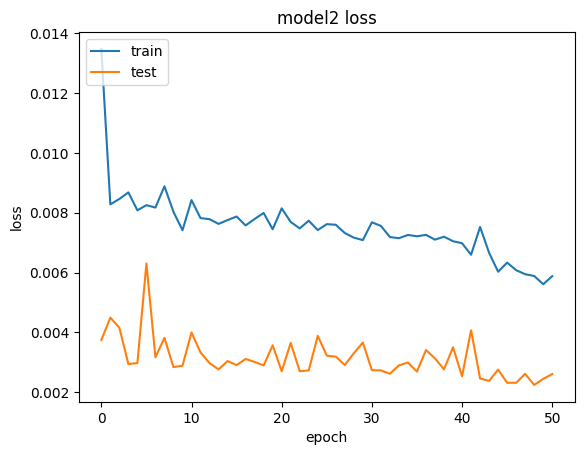

In [27]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) #Zmiana kształtu zbioru X_test
test_loss = model3.evaluate(X_test, y_test) # Ewaluacja modelu na zbiorze testowym
print("Test Loss: ", test_loss) # Wyznaczenie test loss

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019
Test Loss:  0.0018756432691588998


In [29]:
y_pred = model3.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Mean Absolute Error:  0.03235285312020714
Root Mean Square Error:  0.0018756432901126856
